# Notebook for multiple sessions

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import cross_val_score

In [46]:
from importlib import reload

from wombats import utils
from wombats import metrics
from wombats import models
import random
# if changes to the files run this to reload the moduls
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

In [4]:
#data_file = Path('/home/alexgonzalez/Documents/data/steinmetz/steinmetz_all.npy')
data_file = Path('../steinmetz/steinmetz_all.npy')
data_folder = Path('../data/steinmetz/')
if not data_file.exists():
    data = utils.load_steinmentz()
    data_folder.mkdir(parents=True)
    data_file.touch()
    np.save(data_file, data)
else:
    data = np.load(data_file, allow_pickle=True)

FileExistsError: [Errno 17] File exists: '../data/steinmetz'

In [5]:
n_sessions = len(data)

In [6]:
#@title Representative session
#@markdown Let's see which session has more neurons in the areas that we are going to use and how many neurons it has.

brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                  ["MOp", "MOs"],
                  ]
regions = ["visual", "motor"]

def count_neurons_per_brain_area():
    neurons_in_session = []
    for i in range (0,n_sessions):
        session = data[i]
        brain_areas = session['brain_area']

        neurons_in_area = []
        for group in brain_groups:
            count = 0
            for area in group:
                count += np.count_nonzero(brain_areas == area)
            neurons_in_area.append(count)
        neurons_in_session.append(neurons_in_area)
    return neurons_in_session

def plot_areas_sessions(sessions, neurons_in_session):
    fig, ax = plt.subplots(figsize=(18, 5))
    neurons_in_session = np.asarray(neurons_in_session).T
    im = ax.imshow(neurons_in_session)
    ax.set_xticks(np.arange(len(sessions)))
    ax.set_yticks(np.arange(len(regions)))
    ax.set_yticklabels(regions)
    ax.set_xticklabels(sessions)
    
    for i in range(len(regions)):
        for j in range(len(sessions)):
            text = ax.text(j, i, str(neurons_in_session[i,j]),
                           ha="center", va="center", color="w")
    ax.set_title("Number of neurons per brain area")
    fig.tight_layout()
    plt.show()
    
    
def get_representative_sessions(min_visual=1, min_motor=1):
    representative_sessions = []
    new_neurons = []
    neurons_in_session = count_neurons_per_brain_area()
    
    for session, n_neurons in enumerate(neurons_in_session):
        if(n_neurons[0] > min_visual and n_neurons[1] > min_motor):
            representative_sessions.append(session)
            new_neurons.append(n_neurons)
    plot_areas_sessions(representative_sessions, new_neurons)
    
    return representative_sessions


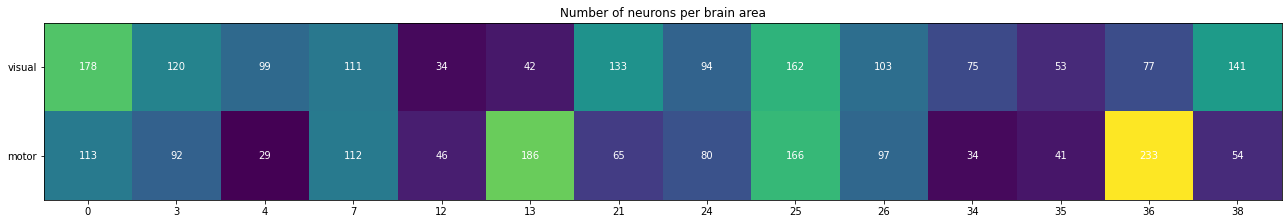

In [7]:
idx_session  = get_representative_sessions(20, 20)
# Get subset of selected sessions:
data = data[idx_session]

In [8]:
# DEFAULTS
N_XVAL = 10 # cross validation
DOWNSAMPLING_FACTOR  = 'all'  # 'all'-> implies that the analisis time window is compressed to 1
TRIAL_RANGE = np.array([-0.5, 2])
SAMP_RATE = 0.01

N_SESSIONS = len(data)


In [28]:
print(N_SESSIONS)

14


## Functions to get coefficients

In [10]:
## TODO: alternatives for these functions.
# take out obtaining performance and the prediction?

def get_a1(stim, region_dat):
    
    n_region_neurons = region_dat.shape[0]
    n_analysis_time_bins = region_dat.shape[2]
    
    if n_analysis_time_bins==1:
        region_dat = region_dat.squeeze().T  # reshapes from neurons x trial x 1 bin, to trials x neurons
        
        # Model Linear Regression
        encoder, encoder_coefs, encoder_model = models.train_linear_encoder(stim, region_dat)
        A1 = encoder_coefs
        
        # get training data prediction
        region_dat_hat = encoder(stim)  
    
        # get performance
        encoder_perf = get_xval_perf(model=encoder_model, input_data=stim, output_data=region_dat, scoring='explained_variance')
    else:
        # need to implement a method for time window iteration
        raise NotImplementedError
    
    return A1, encoder_perf, region_dat_hat


def get_a2(region1_dat, region2_dat):
    """
    :param region1_dat: generated output from a1
    """
    
    # Get data
    #region2_dat = utils.get_region_data(train_set, region=region2, data_type='fr') 
    n_region2_neurons = region2_dat.shape[0]
    n_analysis_time_bins = region2_dat.shape[2]
    
    if n_analysis_time_bins==1:
        region2_dat = region2_dat.squeeze().T  # reshapes from neurons x trial x 1 bin, to trials x neurons
        
        # Model Linear Regression
        transition, transition_coefs, transition_model = models.train_linear_transition(region1_dat, region2_dat)
        A2 = transition_coefs
        
        # get training data prediction
        region2_dat_hat = transition(region1_dat)

        # get performance
        transition_perf = get_xval_perf(model=transition_model, input_data=region1_dat, output_data=region2_dat, scoring='explained_variance')  

    else:
        # need to implement a method for time window iteration
        raise NotImplementedError
    
    return A2, transition_perf, region2_dat_hat


def get_a3(region_dat, output):
    n_region_neurons = region_dat.shape[0]
    n_analysis_time_bins = region_dat.shape[2]
    
    if n_analysis_time_bins==1:
        region_dat = region_dat.squeeze().T  # reshapes from neurons x trial x 1 bin, to trials x neurons
        
        # Model Linear Regression
        decoder, decoder_coefs, decoder_model = models.train_logistic_decoder(region_dat, output)
        A3 = decoder_coefs
        
        # get prediction
        region_dat_hat = decoder(region_dat)
    
        # get performance
        decoder_perf = get_xval_perf(model=decoder_model, input_data=region_dat, output_data=output_data, scoring='balanced_accuracy')
    else:
        # need to implement a method for time window iteration
        raise NotImplementedError
    
    return A3, decoder_perf, region_dat_hat

def get_full_model_output(stim, A1, A2, A3, output_type='bool'):
    linear_output = stim @ A1 @ A2 @ A3
    
    if output_type=='prob':
        output = utils.sigmoid(linear_output).flatten()
    elif output_type == 'bool':
        output = (linear_output>0).flatten()
        
    return output


In [11]:
def get_xval_perf(model, input_data, output_data, n_xval=N_XVAL, scoring='explained_variance'):
    
    if output_data.ndim==1:
        output_data = output_data[:, np.newaxis]

    n_outputs = output_data.shape[1]
    
    perf = np.zeros((n_outputs, n_xval))
    for output_idx in range(n_outputs):
        perf[output_idx] = cross_val_score(model, input_data, output_data[:, output_idx], cv=n_xval, scoring=scoring)
        
    return perf

def regression_performance_by_neuron(data, data_hat, xval_perf):
    #MSE and R2 per unit
    scores = pd.DataFrame(columns = ['r2', 'xval_r2', 'mse', 'nrmse'])
    scores['r2'] = metrics.r2(data.T, data_hat.T)
    scores['mse'] = metrics.mse(data.T, data_hat.T)
    scores['nrmse'] = metrics.nrmse(data.T, data_hat.T)
    scores['xval_r2'] = np.median(xval_perf,axis=1)

    return scores.mean()

# TODO: full model metrics
# (1) against animal choice 
# (2) against correct choice



In [70]:
##%%time 

region1 = 'visual'
region2 = 'motor'
data_type = 'fr'
analysis_time_window =  np.array([0,0.5]) # time window to analizee


exclude_pre = abs(analysis_time_window[0]-TRIAL_RANGE[0])
exclude_post  = abs(analysis_time_window[1]-TRIAL_RANGE[1])

data_set = [None] * N_SESSIONS

A1 = {i:[] for i in range(N_SESSIONS)}
encoder_perf = {i:[] for i in range(N_SESSIONS)}

A2 = {i:[] for i in range(N_SESSIONS)}
transition_perf = {i:[] for i in range(N_SESSIONS)}

A3 = {i:[] for i in range(N_SESSIONS)}
decoder_perf = {i:[] for i in range(N_SESSIONS)}

full_model_scores = {i:[] for i in range(N_SESSIONS)}
full_model_val_scores = {i:[] for i in range(N_SESSIONS)}

for session in range(N_SESSIONS):
#     print(session)
    data_set[session] = utils.filter_no_go_choice(data[session])
    data_set[session]['fr'] = utils.spikes_to_fr(data_set[session]['spks'], 
                                    samp_rate=SAMP_RATE, 
                                    downsampling_factor=DOWNSAMPLING_FACTOR, 
                                    exclude_pre=exclude_pre, 
                                    exclude_post=exclude_post,
                                   )
    
    
    train_set, val_set = utils.split_validation_set(data_set[session])    
    
    stim = train_set['stims']
    region1_data = utils.get_region_data(train_set, region=region1, data_type=data_type) 
    region2_data = utils.get_region_data(train_set, region=region2, data_type=data_type) 
    output = train_set['response']>0
    
    A1[session], encoder_perf[session], encoder_output  = get_a1(stim, region1_data)
    A2[session], transition_perf[session], transition_output  = get_a2(encoder_output, region2_data)  ## input is encoder output
#     A3[session], decoder_perf[session], decoder_output  = get_a3(region2_data, output)
    
    ## up to above is correct
    ## change full model ouput to give subjectiver performance (subject choice == model output) 
    ## objective performance (correct output / contrast == model output)
    ## store subject performance (correct output / contrast == subject choice)
    
    ## full model score should store the above.
#     full_model_output = get_full_model_outout(stim, A1[session], A2[session], A3[session])
    
    ## validation set
    stim_val = val_set['stims']
    output_val = val_set['response']>0

    break
        

In [74]:
def A1_pert(encoder_output, n_pert):
    # perturbar por fila/row
    trial, neuron = encoder_output.shape
    list_pert = list(np.arange(neuron-1))
    x = random.sample(list_pert, n_pert)
    encoder_output[:,x] = 0
    new_encoder = encoder_output
    
    return new_encoder, x


In [75]:
new_encoder_output, pert_neu = A1_pert(encoder_output, 10)

In [76]:
print(pert_neu)

[60, 62, 165, 73, 18, 162, 21, 36, 105, 108]


In [77]:
new_encoder_output[:,60]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [31]:
stim # columna 1 no importa. Columna 2 y 3 contraste,

array([[1.  , 1.  , 0.  ],
       [1.  , 0.  , 0.5 ],
       [1.  , 1.  , 0.5 ],
       [1.  , 0.5 , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 1.  , 0.5 ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.5 , 0.25],
       [1.  , 1.  , 0.  ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.  , 1.  ],
       [1.  , 1.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.5 , 0.25],
       [1.  , 0.25, 1.  ],
       [1.  , 1.  , 0.5 ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.25],
       [1.  , 0.5 , 1.  ],
       [1.  , 0.25, 0.  ],
       [1.  , 1.  , 0.25],
       [1.  , 0.  , 0.5 ],
       [1.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.5 ],
       [1.  , 0.  , 1.  ],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.25, 0.25],
       [1.  , 0.5 , 0.  ],
       [1.  , 0.  , 1.  ],
 

In [21]:
from sklearn.linear_model import LinearRegression
transition_model =  LinearRegression(fit_intercept=False)

get_xval_perf(model=transition_model, input_data=encoder_output, output_data=region2_data.squeeze().T, scoring='explained_variance')

array([[-0.02364648, -0.34645026, -0.19626273, ...,  0.08014788,
        -0.01459022, -0.02657762],
       [ 0.02129328,  0.05625523,  0.02480889, ..., -0.00446165,
         0.        , -0.05538559],
       [-0.1595742 ,  0.38423209,  0.31343135, ..., -0.74435528,
        -0.2324751 ,  0.09542615],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03840297,  0.        ,  0.05387747, ..., -0.09689126,
        -0.01677844,  0.01414237],
       [ 0.00636282,  0.06527715,  0.00889748, ..., -0.28528214,
         0.        ,  0.07493322]])

In [22]:
models = reload(models)
decoder, decoder_coefs, decoder_model = models.train_logistic_decoder(region2_data.squeeze().T, output)

input_data = region2_data.squeeze().T
output_data = output

n_xval=10
scoring = 'balanced_accuracy'
model = decoder_model

if output_data.ndim==1:
    output_data = output_data[:, np.newaxis]
       
n_outputs = output_data.shape[1]

perf = np.zeros((n_outputs, n_xval))
for output_idx in range(n_outputs):
    perf[output_idx] = cross_val_score(model, input_data, output_data[:, output_idx], cv=n_xval, scoring=scoring)


In [101]:
perf

array([[0.92857143, 1.        , 0.91666667, 0.92857143, 0.91666667,
        1.        , 0.91666667, 0.91666667, 1.        , 0.91666667]])

In [52]:
output_data.shape

(126, 113)

In [14]:
data_set = [None] * N_SESSIONS

session=0
data_set[session] = utils.filter_no_go_choice(data[session])
data_set[session]['fr'] = utils.spikes_to_fr(data_set[session]['spks'], 
                                samp_rate=SAMP_RATE, 
                                downsampling_factor=DOWNSAMPLING_FACTOR, 
                                exclude_pre=EXCLUDE_PRE, 
                                exclude_post=EXCLUDE_POST,
                               )

train_set, val_set = utils.split_validation_set(data_set[session])    

In [17]:
train_set['response']

array([ 1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,
        1.,  1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,
        1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,
       -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1.,
       -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [ ]:
## perturbaciones en A1: encoder to 0. to afectar la performance de A2